In [20]:
import pandas as pd
import numpy as np

In [21]:
# 1. Load data (place train.csv and test.csv in the same folder)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("gender_submission.csv")


In [22]:
display(train.head())
display(train.info())
display(train.describe())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


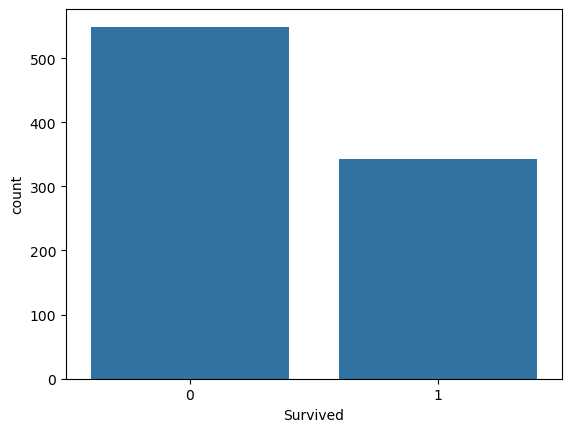

In [23]:
# 2. Simple EDA examples
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="Survived", data=train)
plt.show()

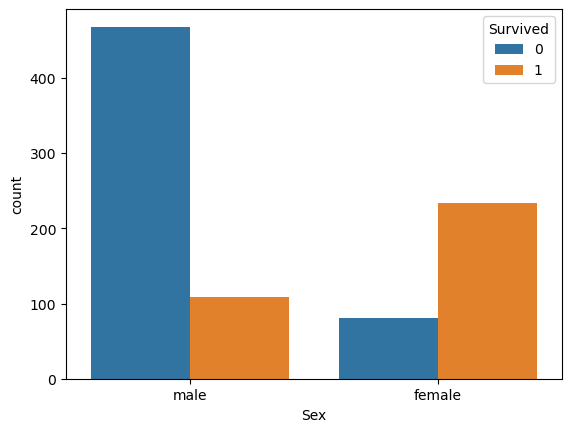

In [24]:
sns.countplot(x="Sex", hue="Survived", data=train)
plt.show()

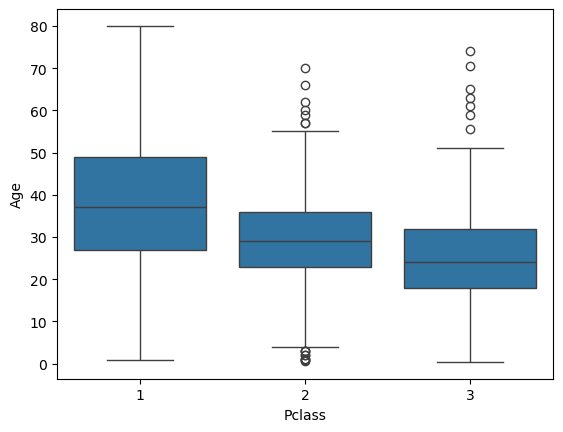

In [25]:
sns.boxplot(x="Pclass", y="Age", data=train)
plt.show()

In [26]:
# 3. Feature engineering / preprocessing
def preprocess(df):
    df = df.copy()
    # Title from name
    df['Title'] = df['Name'].str.extract(r',\s*([^.]*)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],
                                       'Rare')
    df['Title'] = df['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})
    # Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    # Is alone
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    # Fill Embarked
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    # Fill Fare in test set
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    # Age: fill with median of Title groups when possible
    df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))
    df['Age'] = df['Age'].fillna(df['Age'].median())
    # Drop columns we won't use
    df = df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, errors='ignore')
    # Encode categorical
    df = pd.get_dummies(df, columns=['Sex','Embarked','Title'], drop_first=True)
    return df

In [27]:
train_proc = preprocess(train)
test_proc = preprocess(test)

In [28]:

# Align columns (train/test)
train_proc, test_proc = train_proc.align(test_proc, join='left', axis=1, fill_value=0)

X = train_proc.drop('Survived', axis=1)
y = train_proc['Survived']



In [29]:
# 4. Train / eval simple models
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

print("LogReg CV:", cross_val_score(logreg, X, y, cv=cv, scoring='accuracy').mean())
print("RandomForest CV:", cross_val_score(rf, X, y, cv=cv, scoring='accuracy').mean())



LogReg CV: 0.8271734354403364
RandomForest CV: 0.8170547988199109


In [31]:
# Fit best model and predict on test
rf.fit(X, y)
preds = rf.predict(test_proc.drop('Survived', axis=1, errors='ignore'))


In [32]:
# Prepare submission
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': preds})
output.to_csv('submission.csv', index=False)
print("Saved submission.csv")

Saved submission.csv


In [33]:
pd.read_csv("submission.csv").head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
